# 1. 토큰화

1. stemming: 일일이 어미를 찾아 제외하는 규칙 기반 방식 어간 추출
2. lemmatization: 알려진 단어 형태 사전을(명시적이고 사람이 구축한 시스템) 사용하고 문장에서 단어의 역할을 고려
     - 정규화: 두 처리 방식, 표제어 추출과 어간 추출은 단어의 정규화의 한 형태로 볼 수 있다.

In [8]:
import spacy
import nltk

In [9]:
# spacy의 영어 모델을 로드합니다.
en_nlp = spacy.load('en')

# nltk PorterStemmer 객체 생성한다.
stemmer = nltk.stem.PorterStemmer()

# spacy 표제어 추출과 nltk 어간 추출을 비교하는 함수
def compare_normalization(doc):
    doc_spacy = en_nlp(doc)
    
    print("표제어: ")
    print([token.lemma_ for token in doc_spacy])
    
    print("어간: ")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [10]:
compare_normalization(u"Our meeting today was worse than yesterday," 
                       "i'm scared of meeting the clients tomrrow. ")

표제어: 
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', "i'm", 'scar', 'of', 'meet', 'the', 'client', 'tomrrow', '.']
어간: 
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', "i'm", 'scare', 'of', 'meet', 'the', 'client', 'tomrrow', '.']


- 표제어 추출은 어간 추출보다 훨씬 복잡한 처리를 거친다. 하지만 머신러닝을 위해 토큰 정규화를 할 때는 어간 추출보다 좋은 결과를 낸다.

# 2. KoNLPy

In [1]:
import konlpy
import pandas as pd
import numpy as np

### Data

In [2]:
# train
df_train = pd.read_csv('data/ratings_train.txt', delimiter='\t', keep_default_na=False)
df_train.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [3]:
text_train = df_train['document'].as_matrix()
y_train = df_train['label'].as_matrix()

/anaconda3/envs/base-workspace/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/anaconda3/envs/base-workspace/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [4]:
# test
df_test = pd.read_csv('data/ratings_test.txt', delimiter='\t', keep_default_na=False)
text_test = df_test['document'].as_matrix()
y_test = df_test['label'].as_matrix()

/anaconda3/envs/base-workspace/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/base-workspace/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [5]:
len(text_train), np.bincount(y_train)

(150000, array([75173, 74827]))

In [6]:
len(text_test), np.bincount(y_test)

(50000, array([24827, 25173]))

### Konlpy

In [10]:
from konlpy.tag import Twitter

# KoNLPy Twitter 객체
twitter_tag = Twitter()

/anaconda3/envs/base-workspace/lib/python3.6/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [11]:
# 매개변수에 주입할 함수
def twitter_tokenizer(text):
    return twitter_tag.morphs(text)

In [14]:
twitter_tokenizer("안녕하세요. 즐겁게 지내고 계시나요?")

['안녕하세요', '.', '즐겁게', '지내고', '계시나요', '?']

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

twit_param_grid = {
    'tfidfvectorizer__min_df': [3, 5, 7],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,3)]}
twit_pipe = make_pipeline(TfidfVectorizer(tokenizer=twitter_tokenizer), LogisticRegression())
twit_grid = GridSearchCV(twit_pipe, twit_param_grid)

In [22]:
twit_grid.fit(text_train[0:1000], y_train[0:1000])
print("최상 교차 검증 점수: {:.3f}".format(twit_grid.best_score_))
print("최적 교차 검증 매개변수: ", twit_grid.best_params_)

/anaconda3/envs/base-workspace/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/base-workspace/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


최상 교차 검증 점수: 0.704
최적 교차 검증 매개변수:  {'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 1)}


In [26]:
X_test_konlpy = twit_grid.best_estimator_.named_steps['tfidfvectorizer'].transform(text_test)

In [27]:
score = twit_grid.best_estimator_.named_steps['logisticregression'].score(X_test_konlpy, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.705


### MeCab - C++ 기반

- Mecab을 사용한 그리디 서치에서는 LogisticRegression 규제 매개변수 C 범위를 좀 더 넓혀 적용한다.

# 7.9 토픽 모델링과 문서 군집화

### Latent Dirichlet Analysis

- 자주 나타나는 단어의 그룹을 찾는 것이다. 또 LDA는 각 문서에 토픽의 일부가 혼합되어 있다고 간주한다. 머신러닝에서 토픽은 우리가 말하는 주제가 아니라 추출한 성분이다.

In [1]:
from tqdm import tqdm, tnrange
from sklearn.datasets import load_files
reviews_train = load_files("data/aclImdb/train/")

# 텍스트와 레이블을 포함하는 Bunch 객체를 반환
text_train, y_train = reviews_train.data, reviews_train.target

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

- 10개의 토픽으로 토픽 모델을 학습한다.

In [4]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=10, learning_method='batch', max_iter=25, random_state=0)

In [9]:
for i in tnrange(1, desc='time'):
    document_topics = tqdm(lda.fit_transform(X))

/anaconda3/envs/base-workspace/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
  0%|          | 0/25000 [00:00<?, ?it/s]

In [10]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 10000)


### 토픽 확인

In [14]:
import numpy as np
import mglearn

In [19]:
lda.components_.shape

(10, 10000)

In [16]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=range(10),
                           feature_names=feature_names,
                           sorting=sorting,
                           topics_per_chunk=5,
                           n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
director      show          book          family        funny         
work          series        original      young         comedy        
performance   war           10            father        cast          
actors        episode       now           us            role          
cast          tv            again         woman         humor         
screen        years         world         own           fun           
performances  american      saw           world         jokes         
role          episodes      read          real          actors        
both          world         didn          mother        performance   
quite         shows         am            between       always        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

In [20]:
lda100 = LatentDirichletAllocation(n_topics=100,
                                   learning_method='batch',
                                   max_iter=25,
                                   random_state=0)
document_topics100 = lda100.fit_transform(X)

/anaconda3/envs/base-workspace/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [22]:
topics = np.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97])

In [23]:
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=7, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      
drew          didn          ben           emma          years         role          ship          
baseball      going         lines         elvira        saw           oscar         titanic       
maria         seemed        actors        jeremy        again         award         crew          
sports        things        director      hudson        remember      actor         day           
whale         doesn         audience      paltrow       ago           picture       world         
ben           interesting   every         sirk          now           won           air           
red           nothing       worst         austen        watched       roles         sea           
angels        bit           without       bacall        old           supporting    lost          
barrymore 

In [25]:
from matplotlib import pyplot as plt

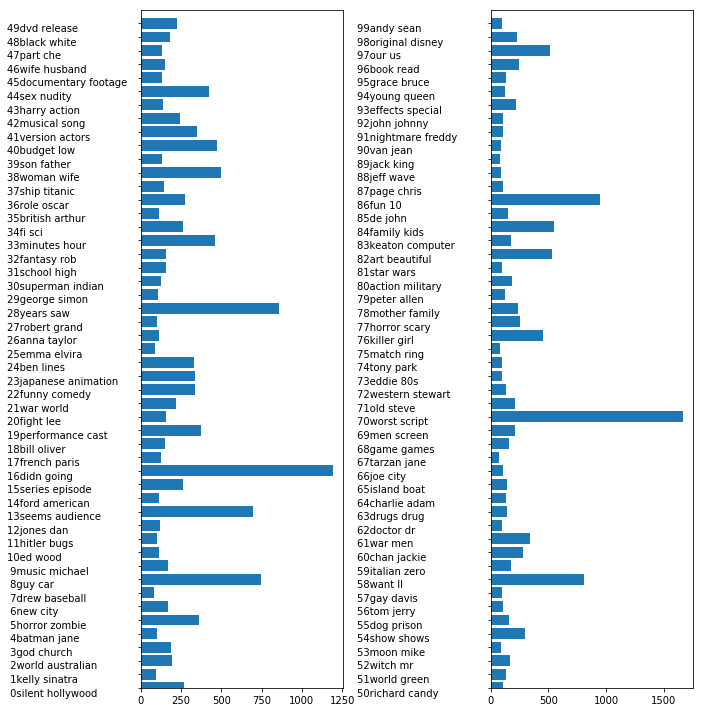

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2}".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]

# 열이 2개인 막대 그래프
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_ylim(0, 50)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

- LDA 는 확률적 알고리즘이기에 random_state를 바꾸면 결과가 많이 달라진다.